In [6]:
import random
import networkx as nx
import csv
import numpy as np
import pymetis
from multiprocessing import Queue as q
from threading import Thread
import time
import multiprocessing as mp
import loadRoadNetCa ,loadRoadNetPa , loadRoadNetTx , loadHepTh ,loadDeezer ,loadCaGrQc ,loadLastfmAsia ,loadOregon ,load_youtube ,load_asSkitter
from matplotlib import pyplot as plt

Load All the Data Graphs

In [2]:
dataGraphs = []
dataGraphs.append(loadRoadNetCa.loadgraph())
dataGraphs.append(loadRoadNetTx.loadgraph())
dataGraphs.append(loadRoadNetPa.loadgraph())
dataGraphs.append(loadDeezer.loadgraph())
dataGraphs.append(loadHepTh.loadgraph())
dataGraphs.append(loadCaGrQc.loadgraph())
dataGraphs.append(loadLastfmAsia.loadgraph())
dataGraphs.append(loadOregon.loadgraph())
dataGraphs.append(load_youtube.loadgraph())
dataGraphs.append(load_asSkitter.loadgraph())

In [3]:
dataGraphsNames = ["roadNet-CA-1965206","roadNet-PA-1088092","roadNet-TX-1379917","Deezer-europe-28281","CA-HepTh-9877","CA-GrQc-5242","LastfmAsia-7624","orego1-10729","youtubeUngraph-1134890","skitter-1696415"]

In [6]:
mp.cpu_count()

256

Pattern Graphs

In [141]:
G = nx.Graph()

G.add_edge("1", "2", weight=9)
#G.add_edge("1", "4", weight=3)
#G.add_edge("1", "3", weight=2)
G.add_edge("1", "5", weight=2)
G.add_edge("2", "5", weight=2)
G.add_edge("2", "3", weight=1)
G.add_edge("3", "4", weight=5)
G.add_edge("3", "5", weight=6)
G.add_edge("4", "2", weight=5)
G.add_edge("4", "5", weight=5)
order = ['1','2','3','4','5']

firstPatternVertexToMatch = order[0]

pg1 = G

In [130]:
G = nx.Graph()

G.add_edge("1", "2", weight=9)
G.add_edge("1", "4", weight=3)
G.add_edge("1", "3", weight=2)
G.add_edge("1", "5", weight=2)
G.add_edge("2", "5", weight=2)
G.add_edge("2", "3", weight=1)
G.add_edge("3", "4", weight=5)
G.add_edge("3", "5", weight=6)
G.add_edge("4", "2", weight=5)
G.add_edge("4", "5", weight=5)
order = ['1','2','3','4','5']

firstPatternVertexToMatch = order[0]
pg2 = G

In [117]:
G = nx.Graph()

G.add_edge("1", "2", weight=9)
G.add_edge("2", "3", weight=2)
G.add_edge("3", "4", weight=5)
G.add_edge("3", "5", weight=6)
G.add_edge("4", "5", weight=4)
G.add_edge("5", "6", weight=7)
G.add_edge("6", "7", weight=3)
G.add_edge("7", "8", weight=4)

order2 = ['1','2','3','4','5','6','7','8']

firstPatternVertexToMatch = order[0]
pg3 = G

Hueristic

In [142]:
def hueristic1(G):
    source = random.choice(list(G.nodes))
    shortest_paths = nx.shortest_path(G, source=source)
    target = max(shortest_paths, key=lambda i: len(shortest_paths[i]))
    diameter = len(shortest_paths[target])
    print(diameter)
    n = len(G.nodes)
    return (2*diameter)/n , n/(2*diameter)

In [143]:
print(hueristic1(pg1))

2
(0.8, 1.25)


In [22]:
def randomWalkOnPattern(G , order , n_exp ,n_paths):
    paths = {}
    for start in order:    
        for i in range(50000):
            path = [start]
            curr = start
            delta = 0.0001
            while True:
                candidates = list(set(order) - set(path))
                if candidates == []:
                    break
                w_candidates = []
                for candidate in candidates:
                    try:
                        w_candidates.append(G[curr][candidate]['weight'])
                    except:
                        w_candidates.append(delta)
                curr = random.choices(candidates, weights= w_candidates)[0]
                path.append(curr)
            try:
                paths[tuple(path)] += 1
            except:
                paths[tuple(path)] = 1
    paths = sorted(paths.items(), key=lambda x:x[1],reverse=True)
    return paths[0:n_paths]

In [23]:
randomWalkOnPattern(pg1,order,1000,5)

[(('3', '4', '5', '2', '1'), 20966),
 (('5', '4', '3', '2', '1'), 17939),
 (('3', '4', '2', '1', '5'), 16955),
 (('5', '4', '2', '1', '3'), 15929),
 (('1', '2', '4', '5', '3'), 15794)]

Find All the exact Pattern matches for ground truth (backtracking algo withour considering any isomorphism)

In [25]:
filename = None
dataGraph = None
patternGraph1 = None

def nextPatternVertexToMatch(f , order):
    return order[len(f)]



def intersect(c , v):
    if c == None:
        return [node for node in v]
    c = [node for node in v if node in c]
    return c 


def RefineCandidates(f , ui):
    c = None
    for i in range(0, len(f)):
        if patternGraph1.has_edge(f[i][0] , ui):
            adjOfVi = dataGraph[f[i][1]].keys()
            c = intersect(c ,adjOfVi)
    return c 



def subgraphSearch(f):
    if(len(f) == len(order)):
        with open(filename, 'a') as f_object:
            writer_object = csv.writer(f_object)
            matched = [a[1] for a in f]
            writer_object.writerow(matched)
            f_object.close()
    else:
        ui = nextPatternVertexToMatch(f , order)
        ci = RefineCandidates(f , ui)
        matched = [a[1] for a in f]
        for vk in ci:
            if vk in matched:
                continue
            f.append((ui ,vk))
            subgraphSearch(f)
            f.pop()

In [78]:
def find_exact_matches(G, i , j):
    patternGraph1 = G
    dataGraph = dataGraphs[i]
    filename = dataGraphsNames[i] + str(j)
    for v in range(len(dataGraph)):
        f = []
        f.append((firstPatternVertexToMatch , v))
        subgraphSearch(f)

In [61]:
for i in range(10):
    find_exact_matches(pg1 , i , 1)
    find_exact_matches(pg2 , i , 2)

Random Walk On dataGraph

In [29]:
def random_walk(dataGraph , n):
    walks = []
    for node  in range(len(dataGraph)):
        curr = node
        walk = [node]
        count = 1
        nwalks = 1
        while(nwalks>0):
            while count<n:
                candidates = []
                w_candidates = []
                for node in dataGraph[curr].keys():
                    if node not in walk:
                        candidates.append(node)
                        w_candidates.append(dataGraph[curr][node])
                if candidates == []:
                    nwalks -= 1
                    break
                else:
                    curr = random.choices(candidates, weights= w_candidates)[0]
                    count += 1
                    walk.append(curr)
            if count == n:
                walks.append(walk)
            nwalks -= 1
    return walks

Random walk with tradeoff between BFS and DFS

In [56]:
def random_walk_bfs_dfs(dataGraph ,n , r , e):
    walks = []
    for node  in range(len(dataGraph)):
        curr = node
        prev = node
        rate = 1
        walk = [node]
        count = 1
        nwalks = 1
        while(nwalks>0):
            while count<n:
                candidates = []
                w_candidates = []
                for node in dataGraph[curr].keys():
                    if node not in walk:
                        candidates.append(node)
                        if count == 1:
                            rate = 1
                        elif node in dataGraph[prev].keys():
                            rate = r
                        else:
                            rate = e
                        w_candidates.append(rate * dataGraph[curr][node])
                if candidates == []:
                    nwalks -= 1
                    break
                else:
                    curr = random.choices(candidates, weights= w_candidates)[0]
                    count += 1
                    walk.append(curr)
            if count == n:
                walks.append(walk)
            nwalks -= 1
    return walks

Parllel Random Walk

In [57]:
def parllelWalk(index , dataGraph , memb , k,return_dict):
    walks = []
    check = 0
    nodes = list(dataGraph.keys())
    n = len(nodes)
    i = 0
    while i<n:
        init = True
        if not queues[index].empty():
            item = queues[index].get()
            try:
                curr , count , walk = item
                init = False
            except:
                check += 1
                init = True
        if init:
            walk = [nodes[i]]
            count = 1
            curr = nodes[i]
            i += 1
        while count<len(u):
            candidates = []
            w_candidates = []
            for edge in list(dataGraph[curr].items()):
                if edge[0] not in walk:
                    candidates.append(edge[0])
                    w_candidates.append(edge[1])
            if candidates == []:
                break
            else:
                curr = random.choices(candidates, weights= w_candidates)[0]
                count += 1
                walk.append(curr)
                if memb[curr] != index and count <len(u) :
                    queues[memb[curr]].put([curr , count  , walk])
                    break
        if count == len(u):
            walks.append(walk)
    print(f"Thread : {index} My task completed , check = {check}")
    for i in range(k):
        if i!=index:
            queues[i].put(True)
    
    while check < k-1:
        while not queues[index].empty():
            item = queues[index].get()
            try:
                curr , count , walk = item
                while count<len(u):
                    candidates = []
                    w_candidates = []
                    for edge in dataGraph[curr]:
                        if edge[0] not in walk:
                            candidates.append(edge[0])
                            w_candidates.append(edge[1])
                    if candidates == []:
                        break
                    else:
                        curr = random.choices(candidates, weights= w_candidates)[0]
                        count += 1
                        walk.append(curr)
                        if memb[curr] != index and count <len(u):
                            queues[memb[curr]].put([curr , count  , walk])
                            break
                if count == len(u):
                    walks.append(walk)
            except:
                check += 1
        time.sleep(0.5)
    return_dict[index] = walks
    return 1

In [58]:
rTime = []
for i in range(10):
    rTime.append([])

In [59]:
membs = []

In [60]:
k = 64
membs.append(loadRoadNetCa.membership(k))
membs.append(loadRoadNetTx.membership(k))
membs.append(loadRoadNetPa.membership(k))
membs.append(loadDeezer.membership(k))
membs.append(loadHepTh.membership(k))
membs.append(loadCaGrQc.membership(k))
membs.append(loadLastfmAsia.membership(k))
membs.append(loadOregon.membership(k))
membs.append(load_youtube.membership(k))
membs.append(load_asSkitter.membership(k))
membs.append(load_asSkitter.membership(k))

In [23]:
for j,memb_ in enumerate(membs):
    dataGraph = dataGraphs[j]
    for k in range(1,64,4):
        gp_al = []
        for i in range(k):
            gp_al.append({})
        for node , bucket in enumerate(memb_[(k-1)//4]):
            gp_al[bucket][node] = dataGraph[node]
        a = time.time()
        u = {1,2,3,4,5}
        manager = mp.Manager()
        return_dict = manager.dict()
        queues = [q() for i in range(k)]
        processes = [mp.Process(target=parllelWalk, args=(i , gp_al[i], memb_[(k-1)//4] ,k ,return_dict)) for i in range(k)]
        [p.start() for p in processes]
        result = [p.join() for p in processes]
        b = time.time()
        print(b-a)
        rTime[j].append(b-a)

Thread : 0 My task completed , check = 0
496.133665561676
Thread : 1 My task completed , check = 0
Thread : 0 My task completed , check = 1
Thread : 2 My task completed , check = 2
Thread : 3 My task completed , check = 3
Thread : 4 My task completed , check = 4
128.55685663223267
Thread : 1 My task completed , check = 0
Thread : 3 My task completed , check = 1
Thread : 0 My task completed , check = 2
Thread : 6 My task completed , check = 3
Thread : 2 My task completed , check = 4
Thread : 4 My task completed , check = 5
Thread : 5 My task completed , check = 6
Thread : 7 My task completed , check = 7
Thread : 8 My task completed , check = 8
92.59502601623535
Thread : 2 My task completed , check = 0
Thread : 1 My task completed , check = 0
Thread : 0 My task completed , check = 1
Thread : 4 My task completed , check = 3
Thread : 3 My task completed , check = 3Thread : 5 My task completed , check = 4

Thread : 7 My task completed , check = 6
Thread : 6 My task completed , check = 7
Thr

Process Process-1542:
Process Process-1546:
Process Process-1543:
Process Process-1544:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 318, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()


KeyboardInterrupt: 

  File "/usr/lib/python3.8/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 195, in _finalize_join
    thread.join()
  File "/usr/lib/

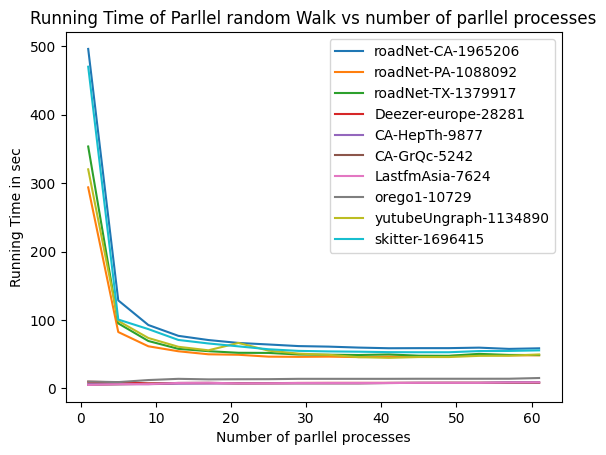

In [52]:

for i in range(10):
    plt.plot([i for i in range(1,64,4)], rTime[i], label=dataGraphsNames[i])
plt.xlabel('Number of parllel processes')
plt.ylabel('Running Time in sec')
plt.title('Running Time of Parllel random Walk vs number of parllel processes')
plt.legend()
plt.savefig("RunningTime.png")

Top 100 GROUND TRUTH

In [53]:
expectedTop100 = []

Pattern 1 

In [62]:
for i in range(10):
    expected_walks = []
    filename = dataGraphsNames[i] + "1"
    path = ['1','2','3','4','5']
    with open(filename , 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            walk = [int(n) for n in row]
            deviation = exact_deviation(pg1 , path,walk)
            expected_walks.append((deviation , walk))
    sorted_ew = sorted(expected_walks, key=lambda x:x[0])
    expectedTop100.append([x[1] for x in sorted_ew[0:100])
    

Pattern 2

In [63]:
for i in range(10):
    expected_walks = []
    filename = dataGraphsNames[i] + "2"
    path = ['1','2','3','4','5','6','7','8']
    with open(filename , 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            walk = [int(n) for n in row]
            deviation = exact_deviation(pg2 , path,walk)
            expected_walks.append((deviation , walk))
    sorted_ew = sorted(expected_walks, key=lambda x:x[0])
    expectedTop100.append(sorted_ew[0:100])

In [67]:
def exact_deviation(G ,path , walk):
    bijection = {path[i] : walk[i] for i in range(len(path))}
    deviation = 0
    for a , b in G.edges:
        try:
            deviation += abs(G[a][b]['weight'] - dataGraph[bijection[a]][bijection[b]])
        except:
            deviation += 1000
    return deviation

In [68]:
hits = []

In [69]:
strides = [10000 , 10000 , 10000 , 50,50,50,50,50,10000,10000]

In [70]:
for i in range(10):
    walks = random_walk(dataGraphs[i] , 5)
    count = 0
    n = 0
    hits_ == []
    for walk in walks:
        for path in paths:
            deviation = exact_deviation(pg1 , path , walk))
            n += 1
            if(exactTop100[i][0] >= deviation):
                count += 1
            if(n == strides[i]):
                hits_append(count)
                n = 0 
    hits.append(hits_)
    walks = random_walk_bfs_dfs(dataGraphs[i] , 5 , 1, 0)
    count = 0
    n = 0
    hits_ == []
    for walk in walks:
        for path in paths:
            deviation = exact_deviation(pg1 , path , walk))
            n += 1
            if(exactTop100[i][0] >= deviation):
                count += 1
            if(n == strides[i]):
                hits_append(count)
                n = 0 
    hits.append(hits_)
        walks = random_walk_bfs_dfs(dataGraphs[i] , 5 , 0, 1)
    count = 0
    n = 0
    hits_ == []
    for walk in walks:
        for path in paths:
            deviation = exact_deviation(pg1 , path , walk))
            n += 1
            if(exactTop100[i][0] >= deviation):
                count += 1
            if(n == strides[i]):
                hits_append(count)
                n = 0 
    hits.append(hits_)
    e,r = hueristic1(G)
    walks = random_walk_bfs_dfs(dataGraphs[i] , 5 , r, e)
    count = 0
    n = 0
    hits_ == []
    for walk in walks:
        for path in paths:
            deviation = exact_deviation(pg1 , path , walk))
            n += 1
            if(exactTop100[i][0] >= deviation):
                count += 1
            if(n == strides[i]):
                hits_append(count)
                n = 0 
    hits.append(hits_)

In [ ]:
for i in range(10):
    walks = random_walk(dataGraphs[i] , 8)
    count = 0
    n = 0
    hits_ == []
    for walk in walks:
        for path in paths:
            deviation = exact_deviation(pg2 , path , walk))
            n += 1
            if(exactTop100[i][0] >= deviation):
                count += 1
            if(n == strides[i]):
                hits_append(count)
                n = 0 
    hits.append(hits_)
    walks = random_walk_bfs_dfs(dataGraphs[i] , 8 , 1, 0)
    count = 0
    n = 0
    hits_ == []
    for walk in walks:
        for path in paths:
            deviation = exact_deviation(pg2 , path , walk))
            n += 1
            if(exactTop100[i][0] >= deviation):
                count += 1
            if(n == strides[i]):
                hits_append(count)
                n = 0 
    hits.append(hits_)
        walks = random_walk_bfs_dfs(dataGraphs[i] , 5 , 0, 1)
    count = 0
    n = 0
    hits_ == []
    for walk in walks:
        for path in paths:
            deviation = exact_deviation(pg2 , path , walk))
            n += 1
            if(exactTop100[i][0] >= deviation):
                count += 1
            if(n == strides[i]):
                hits_append(count)
                n = 0 
    hits.append(hits_)
    e,r = hueristic1(G)
    walks = random_walk_bfs_dfs(dataGraphs[i] , 5 , r, e)
    count = 0
    n = 0
    hits_ == []
    for walk in walks:
        for path in paths:
            deviation = exact_deviation(pg2 , path , walk))
            n += 1
            if(exactTop100[i][0] >= deviation):
                count += 1
            if(n == strides[i]):
                hits_append(count)
                n = 0 
    hits.append(hits_)

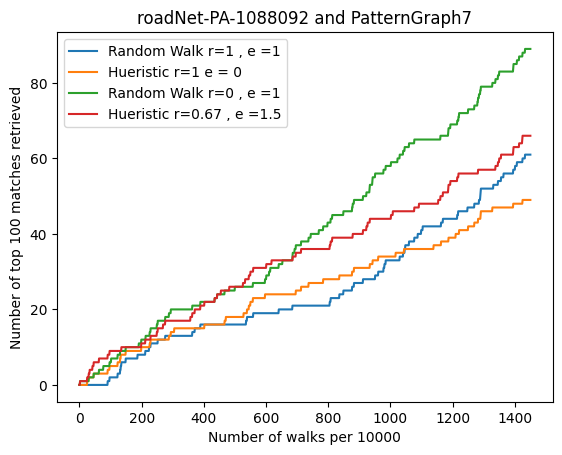

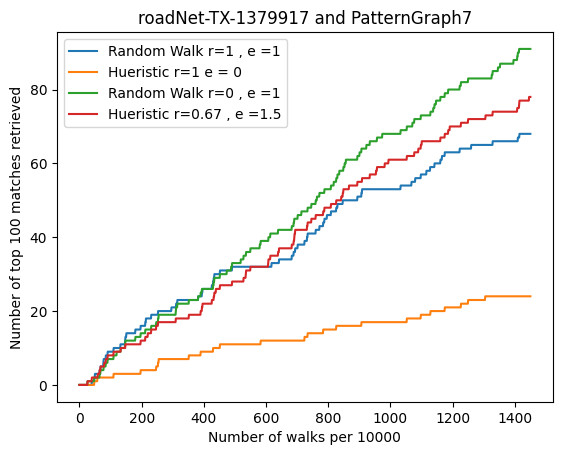

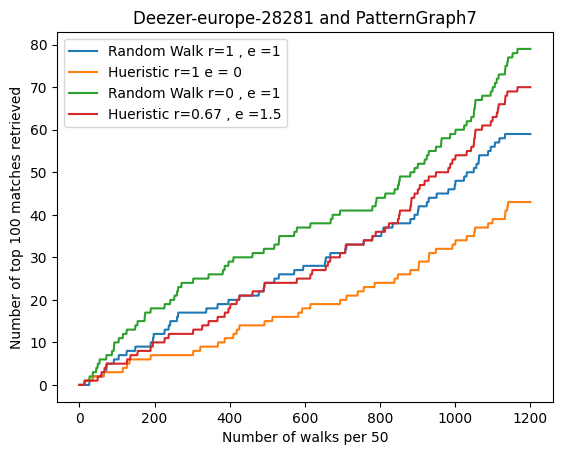

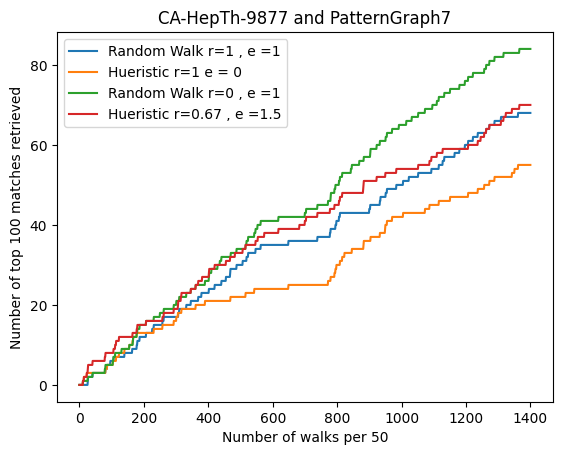

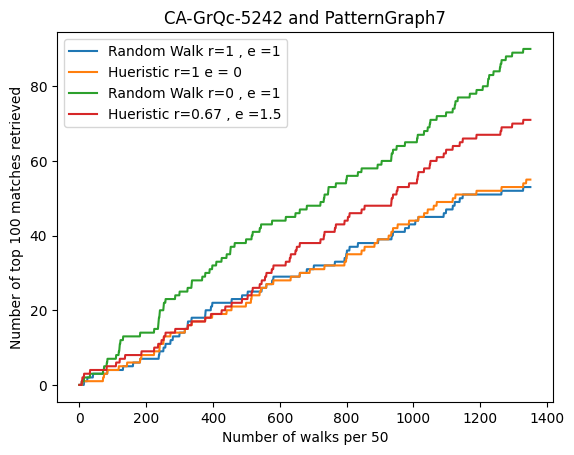

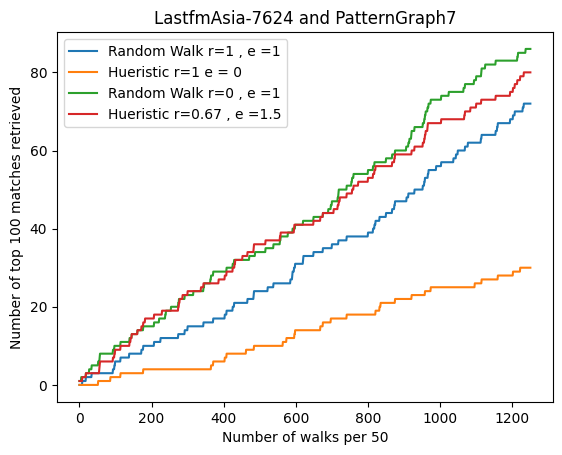

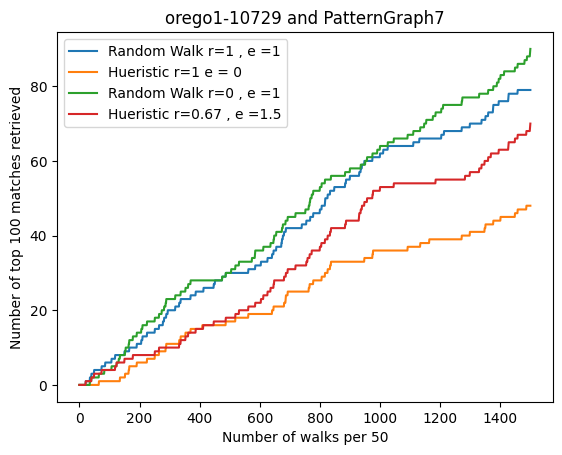

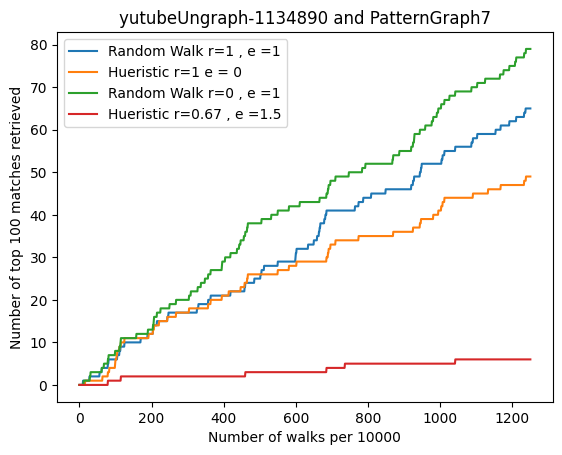

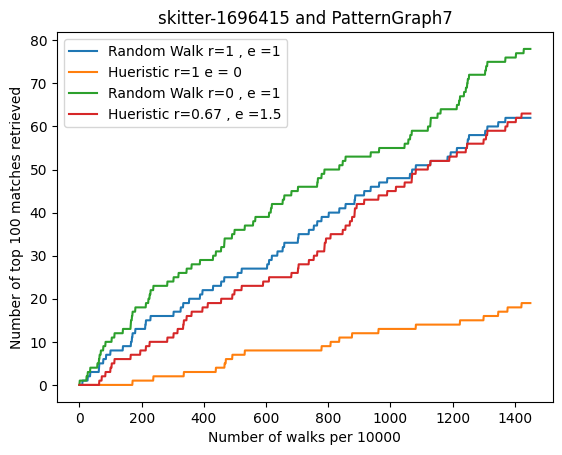

In [150]:
for i in range(1,10):
    plt.plot([i for i in range(b[i]+1)], hits[4*(i-1)+36], label='Random Walk r=1 , e =1')
    plt.plot([i for i in range(b[i]+1)], hits[4*(i-1) + 37], label='Hueristic r=1 e = 0')
    plt.plot([i for i in range(b[i]+1)], hits[4*(i-1) + 38], label='Random Walk r=0 , e =1')
    plt.plot([i for i in range(b[i]+1)], hits[4*(i-1) + 39], label='Hueristic r=0.67 , e =1.5')
    plt.xlabel(f'Number of walks per {strides[i]}')
    plt.ylabel('Number of top 100 matches retrieved')
    plt.title(f'{dataGraphsNames[i]} and PatternGraph7')
    plt.legend()
    name = dataGraphsNames[i] + "Pg7.png"
    plt.savefig(name)
    plt.show()

In [ ]:
j = 1
print(f"badri is {j}")

badri is 1


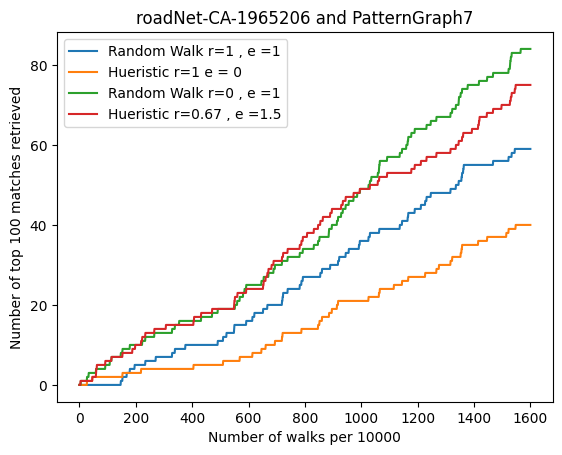

In [161]:
plt.plot([i for i in range(b[0]+1)], hits[0], label='Random Walk r=1 , e =1')
plt.plot([i for i in range(b[0]+1)], hits[1], label='Hueristic r=1 e = 0')
plt.plot([i for i in range(b[0]+1)], hits[2], label='Random Walk r=0 , e =1')
plt.plot([i for i in range(b[0]+1)], hits[3], label='Hueristic r=0.67 , e =1.5')
plt.xlabel(f'Number of walks per {strides[0]}')
plt.ylabel('Number of top 100 matches retrieved')
plt.title(f'{dataGraphsNames[0]} and PatternGraph7')
plt.legend()
name = dataGraphsNames[0] + "Pg7.png"
plt.savefig(name)
plt.show()

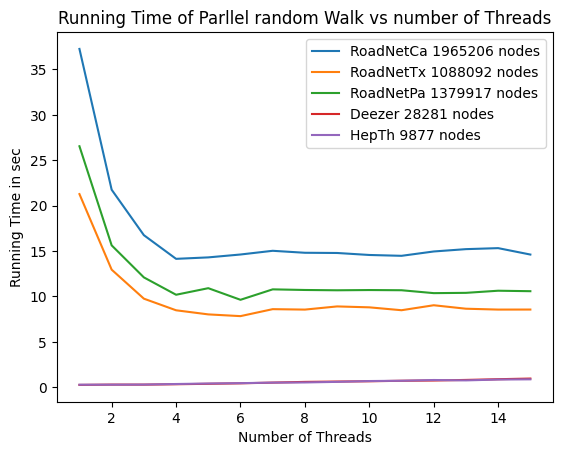